In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 30]

In [2]:
from processa_imagem import ProcessaImagem 
from palo import Palo
from utils import Utils

In [3]:
imgName = '10'
img = cv2.imread('source-img/' + imgName + '.JPG')

In [4]:
utl = Utils()
pro = ProcessaImagem()
img = pro.rotacionar(img)

In [5]:
HEIGHT = 2300
l, img = pro.resize(img, height=HEIGHT)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgTmp = gray.copy()
imgTmp[:, :] = 0

img2 = gray.copy()
img2 = img2[0:200, :400]

LINHASM = 10
COLUNASM = 10

MIN_AREA = 45
MAX_AREA = 4900

In [48]:
flat_object = img.copy()

In [49]:
# resize the image
ratio, flat_object_resized = pro.resize(flat_object, height=HEIGHT)

In [50]:
# make a copy
flat_object_resized_copy = flat_object_resized.copy()

In [51]:
our_cnt = None
our_cnt = pro.processaImagemRoiWarp(flat_object_resized_copy)
warped = None
CORTE = 30
HT_CORTE = 100
HB_CORTE = 150
if our_cnt is not None:
    warped = pro.for_point_warp(our_cnt / ratio, flat_object)
    ratio, warped = pro.resize(warped, height=HEIGHT)
    #utl.mostraImg("flat_object_resized_copy: ", flat_object_resized_copy)
    #cv2.imwrite("tmp/warp.png", warped)
if warped is not None:
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    gray = gray[HT_CORTE:len(gray) - HB_CORTE, CORTE:gray.shape[1] - CORTE]
    clone = warped[HT_CORTE:len(warped)- HB_CORTE , CORTE:warped.shape[1] - CORTE].copy()
else:
    gray = cv2.cvtColor(flat_object_resized, cv2.COLOR_BGR2GRAY)
    gray = gray[HT_CORTE:len(gray)-HB_CORTE, CORTE:gray.shape[1] - CORTE]
    clone = flat_object_resized[HT_CORTE:len(gray), CORTE:gray.shape[1] - CORTE].copy()


9
5048418.0
[[[2128  284]]

 [[  95  293]]

 [[ 265 2962]]

 [[2062 2973]]]


In [52]:
fgbg = cv2.createBackgroundSubtractorMOG2()
fgmask = fgbg.apply(gray)
imgTmp = cv2.absdiff(fgmask, gray)
imgTmp = pro.processaImagem2(imgTmp)

h, cnts, hx = cv2.findContours(imgTmp.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(len(cnts))
cnts2 = cnts.copy()

1035


In [53]:
(cnts, boundingBoxes) = pro.sort_contours(cnts, method="top-to-bottom")

font = cv2.FONT_HERSHEY_SIMPLEX
areas = []
larguras = []
palos = []
cntsTmp = []
cnts_c = np.array(cnts)


In [54]:
#mediaAreas = np.mean(areas)
#desvioAreas = np.std(areas)
#mediaLarguras = np.mean(larguras)
#desvioLarguras = np.std(larguras)
#print(mediaAreas)
cnts_b = cnts_c.copy()
boxes = []
i = 0
print("Total palos",len(cnts_b))
while i < len(cnts_b):
    contornos = cnts_c[i]
    x, y, w, h = cv2.boundingRect(contornos)
    area = cv2.contourArea(contornos)
    epsilion = 0.001 * cv2.arcLength(contornos, True)
    approx = cv2.approxPolyDP(contornos, epsilion, True)
    areaApprox = cv2.contourArea(approx)
    if not (x < CORTE or area < MIN_AREA or area > MAX_AREA or x > imgTmp.shape[1] - CORTE):
        rect = Palo(x, y, w, h)
        rect.setContornos(contornos)
        rect.setArea(area)
        rect.setAreApprox(areaApprox)
        rect.setApprox(approx)
        rect.soma()
        boxes.append(rect)
    i = i + 1
# fim while

Total palos 1035


In [55]:

print('boxes antes: '+str(len(boxes)))

boxes = pro.sortByPositionXY(boxes, clone)


boxes antes: 1001


In [56]:
totalPalos = 0
conta = 0
tempo = 1
tempos = {}
i = 0
print('boxes: '+str(len(boxes)))
while i < len(boxes):
    palo = boxes[i]
    if palo.x < CORTE:
        print('nao')
    if palo.x > CORTE:

        # area = cv2.contourArea(cnts_b[i])
        if palo.area > MIN_AREA and palo.area < MAX_AREA:

            if palo.w > (2 * palo.h):

                #if conta > 40:
                tempos[tempo] = conta
                cv2.putText(clone, str(conta), (palo.x, palo.y - 2), font, 0.8, (0, 0, 255), 2)
                #cv2.rectangle(clone, (palo.x, palo.y), (palo.x + palo.w, palo.y + palo.h), (0, 255, 0), 2)
                #utl.mostraImg("cnts: ", clone)
                #if conta > 40:
                tempo = tempo + 1
                conta = 0

            elif i != len(boxes) - 1 :
                #if palo.w > mediaLarguras + desvioLarguras + 4 and palo.w < palo.h:
                    #conta = conta + 1
                    #cv2.putText(clone, str(conta), (palo.x, palo.y), font, 0.8, (0, 0, 255), 1)
                #else:

                    conta = conta + 1
                    cv2.putText(clone, str(conta), (palo.x, palo.y + palo.h + 20), font, 0.4, (0, 0, 0), 1)

            cv2.rectangle(clone, (palo.x, palo.y), (palo.x + palo.w, palo.y + palo.h), (0, 255, 0), 2)


            cv2.drawContours(clone, [palo.getApprox()], -1, (255, 0, 0), 1)
            #imgCrop = utl.recortar(imgTmp, palo)
            # _, imgCrop=pro.resize(imgCrop, height=30)
            '''
            try:
                cv2.imwrite("tmp/treinamento/" + str(i) + ".png", imgCrop)
            except ValueError:
                print(i)
                print(ValueError)
            #utl.mostraImg("cnts: ", clone)
            # print(conta)
            '''
        if i == len(boxes) - 1:
            # if conta > 40:
            print('parar')
            tempos[tempo] = conta
            break
    i = i + 1
# fim while
print("shape", imgTmp.shape)

print(tempos)


boxes: 1000
parar
shape (2792, 2240)
{1: 186, 2: 269, 3: 135, 4: 206, 5: 199}


In [57]:
diffPalos = {}
for i in range(1, len(tempos)):
    diffPalos[i] = abs(tempos[i] - tempos[i + 1])
totalPalos = sum([int(x) for x in tempos.values()])

print(diffPalos)
print(totalPalos)
somaDiffPalos = sum([int(x) for x in diffPalos.values()])
print(somaDiffPalos)
NOR = round(somaDiffPalos * 100 / totalPalos, 1)
print("NOR: "+str(NOR))


{1: 83, 2: 134, 3: 71, 4: 7}
995
295
NOR: 29.6


In [58]:

cv2.putText(clone, "PALOS: " + str((totalPalos)), (40, 30), font, 0.9, (255, 0, 0), 2)
cv2.putText(clone, "NOR: " + str((NOR)), (220, 30), font, 0.9, (255, 0, 0), 2)
cv2.putText(clone, "INTERVALOS: " + str((tempos)), (400, 30), font, 0.9, (255, 0, 0), 2)
cv2.putText(clone, "IMAGEM: " + str((imgName)), (1200, 30), font, 0.9, (255, 0, 0), 2)
# utl.mostraImg("cnts: ", clone)
# utl.mostraImg("imgTmp: ", imgTmp)
cv2.imwrite("tmp/clone" + imgName + ".png", clone)
cv2.imwrite("tmp/imgTmp-process.png", imgTmp)

True

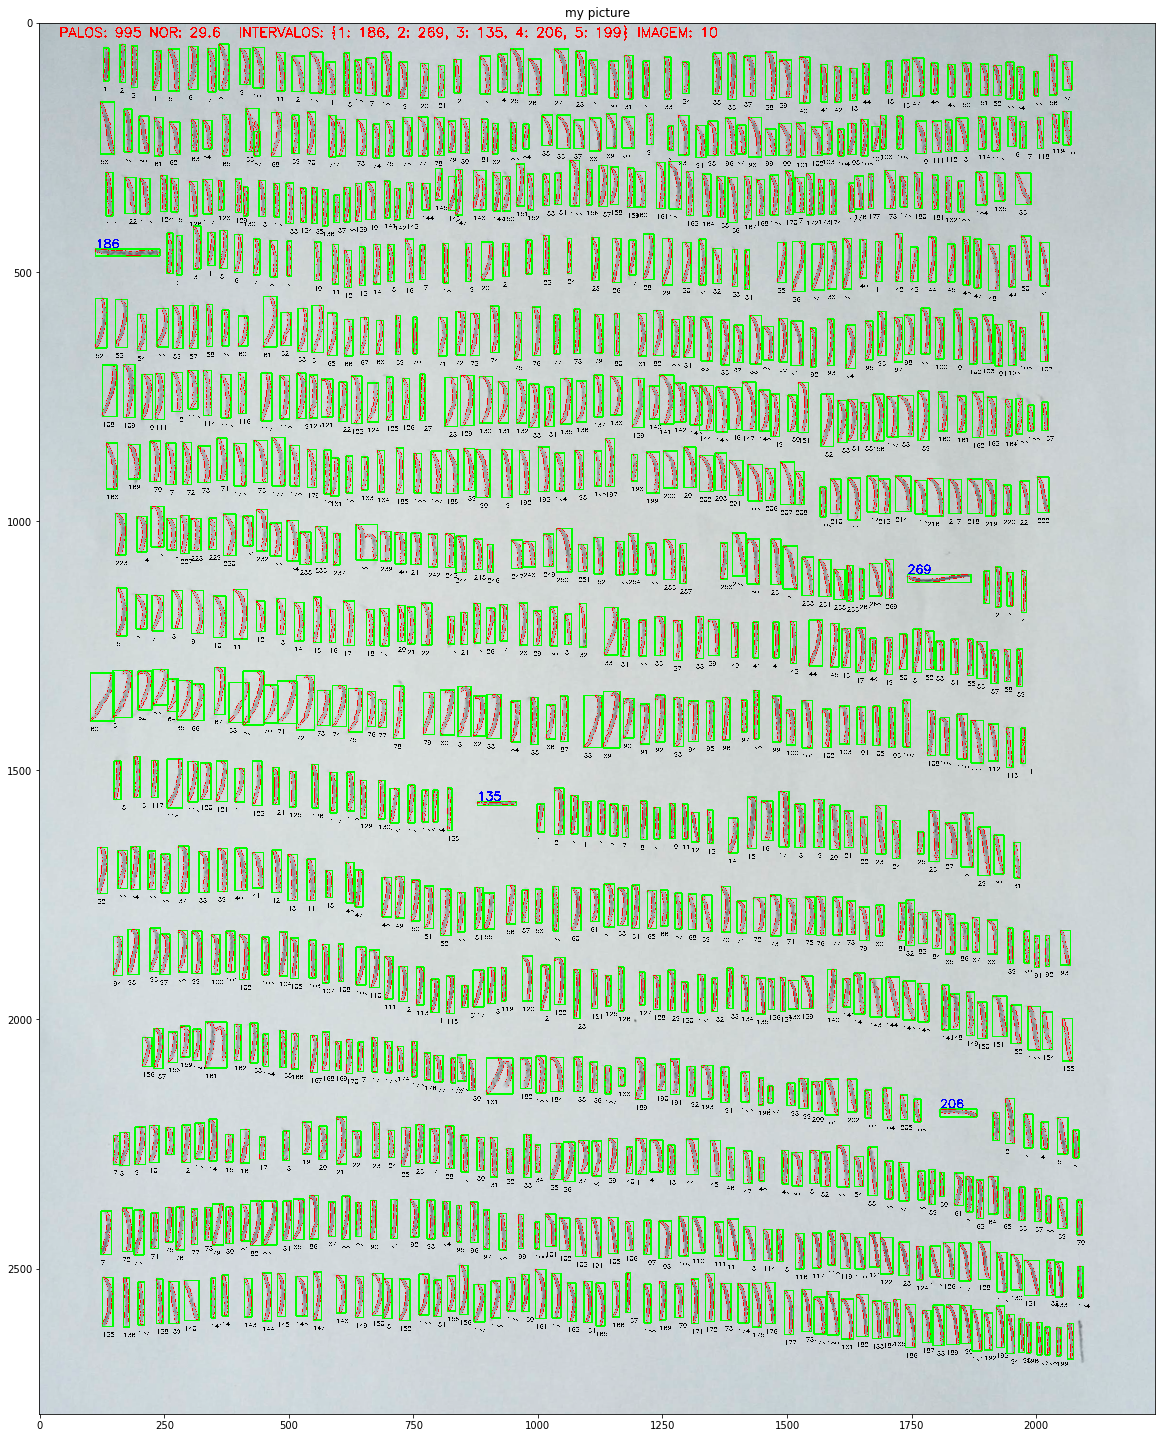

In [64]:
img = cv2.imread('tmp/clone' + imgName + '.png')
plt.title('my picture')
plt.imshow(img)
plt.show()